# 目的

利用 word2vec 的概念，應用於標籤之上。每個標籤都含有一些意義，有些標籤所討論的其實相差不遠。在 Stack Exchange 的問題中，一個標籤跟另一個標籤同時出現的次數，可以說明兩個之間有很大的關聯性。

多層神經網路的功能包含了 feature extraction 與 prediction，在最終目的為預測的過程中，其中中間的 hidden layer 的任務就是將 input 作各式各樣的 representation。如果我們能找到多層神經網路，可以將一標籤映到一個代表其他標籤與它同時出現次數的向量，再抽出中間 hidden layer 的 output，以 word embedding 為概念可以稱其為 tag embedding。

# 使用的函式庫
 - `pandas`
 - `numpy`
 - `tensorflow`
 - `matplotlib`
 - `seaborn`
 
還有一個從 `tensorflow` 的 MNIST dataset 改編來的 `Dataset`，在 batch 抽樣給 `tensorflow` 訓練的過程會比較方便。

In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

dir_in = "inputs/"
csvfile = "cooking.csv"

import sys
sys.path.insert(0, '../../LEARNING/tensorflow/')
sys.path.insert(0, '../../LEARNING/PCA_dl/')
from layers import full_connected
from Dataset import Dataset

# 使用數據集 - Stack Exchange

 - Kaggle 一個競賽所提供 (https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags)
 - 欄位有 `id`、`title`、`content`及`tags`，本 notebook 僅使用 `tags`。

In [57]:
data = pd.read_csv(dir_in+csvfile)
data.head()

,id,title,content,tags
0,1,How can I get chewy chocolate chip cookies?,<p>My chocolate chips cookies are always too c...,baking cookies texture
1,2,How should I cook bacon in an oven?,<p>I've heard of people cooking bacon in an ov...,oven cooking-time bacon
2,3,What is the difference between white and brown...,"<p>I always use brown extra large eggs, but I ...",eggs
3,4,What is the difference between baking soda and...,<p>And can I use one in place of the other in ...,substitutions please-remove-this-tag baking-so...
4,5,"In a tomato sauce recipe, how can I cut the ac...",<p>It seems that every time I make a tomato sa...,sauce pasta tomatoes italian-cuisine


# Tokenization

In [58]:
# 給每個 tag 一個編號
def Tokenizer(stringlst):
    idx = 1
    worddic = dict()
    for phrase in stringlst:
        for word in phrase:
            if word not in worddic:
                worddic[word] = idx
                idx += 1
    return worddic

def flat(hierachy):
    l = []
    for sublst in hierachy:
        for item in sublst:
            l.append(item)
    return l

def topNclose(connect, tag, N):
    taglink   = [item[1] for item in connect if item[0] == tag]
    tagweight = [item[2] for item in connect if item[0] == tag]
    
    sortedindex = np.argsort(tagweight)
    return [taglink[sortedindex[-i]] for i in xrange(N)]

In [59]:
tagslist = data.tags.apply(lambda s: s.split()).get_values()
tagdict = Tokenizer(tagslist)

m = -99
tagsindex = dict()
for key in tagdict.keys():
    if tagdict[key] > m:
        m = tagdict[key]
        tagsindex[m] = key
print("There are {} different tags.".format(m+1))

There are 737 different tags.


# 使用 CBOW 方法總計成一矩陣。

In [169]:
word_count_matrix = np.zeros((m+1, m+1))
for idx in tagsindex.keys():
    for row in tagslist:
        if tagsindex[idx] in row:
            for pair_tag in row:
                word_count_matrix[idx, tagdict[pair_tag]] += 1

# Build Tensorflow Model

- 下面網路是將一個 tag (one-hot vector) 映射到該 tag 的 co-occured tags，用 fullly connected 的方式。

- 這裡可以設定 embedding vector 的 dimension，這裡的設定是 100。

In [198]:
x = tf.placeholder(shape=[None, m+1], dtype=tf.float32)
y = tf.placeholder(shape=[None, m+1], dtype=tf.float32)

l1,      _ = full_connected(x , 20, 'l1', activation='sigmoid')
l2,      _ = full_connected(l1, 20, 'l2', activation='sigmoid')
linear3, _ =  full_connected(l2, 20, 'linear')
l3,      _ = full_connected(linear3, 20, 'l3', activation='sigmoid')
out,     _ = full_connected(l3, m+1, 'out')

loss = tf.reduce_mean(tf.pow(out-y, 2))
optimizer = tf.train.RMSPropOptimizer(0.001).minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

# Train it!

In [199]:
dataset = Dataset(np.eye(m+1), word_count_matrix)
batchsize = 512

for _ in xrange(5000):
    x_batch, y_batch = dataset.next_batch(batchsize)
    feed = {x: x_batch, y: y_batch}
    sess.run(optimizer, feed_dict=feed)
    if (_+1)%100 == 0:
        print("step {}: loss is {}".format(_+1, sess.run(loss, feed_dict={x: np.eye(m+1), y: word_count_matrix})))

step 100: loss is 2.93543505669
step 200: loss is 1.3148856163
step 300: loss is 0.510707378387
step 400: loss is 0.24516633153
step 500: loss is 0.0825515389442
step 600: loss is 0.0214815270156
step 700: loss is 0.00516021624207
step 800: loss is 0.00160298100673
step 900: loss is 0.00113842554856
step 1000: loss is 0.00238138111308
step 1100: loss is 0.000732467684429
step 1200: loss is 0.00146252335981
step 1300: loss is 0.00108523515519
step 1400: loss is 0.000560136220884
step 1500: loss is 0.00097166741034
step 1600: loss is 0.000291389587801
step 1700: loss is 0.000553134363145
step 1800: loss is 0.000433989771409
step 1900: loss is 0.000783890893217
step 2000: loss is 0.00103235128336
step 2100: loss is 0.000570469535887
step 2200: loss is 0.000373589689843
step 2300: loss is 0.000461673073005
step 2400: loss is 0.000446283724159
step 2500: loss is 0.000582377775572
step 2600: loss is 0.00147234159522
step 2700: loss is 0.000454677734524
step 2800: loss is 0.000523985770997
st

# 從第二個 hidden layer 抽取出 output

In [212]:
tagvec = sess.run(l1, feed_dict={x: np.eye(m+1), y: word_count_matrix})

# 為了可以 visualization，把 tagvec 用 PCA 壓到二維空間。

In [213]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(tagvec)
compressed = pca.transform(tagvec)

In [214]:
def visualiztion(xmin, xmax, ymin, ymax):
    fig, ax = plt.subplots()
    ax.scatter(compressed[:,0], compressed[:,1])

    for i, txt in enumerate(tagdict.keys()):
        ax.annotate(txt, (compressed[i,0], compressed[i,1]))
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

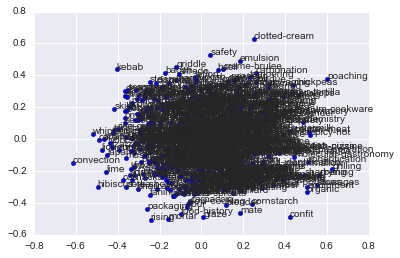

In [215]:
fig, ax = plt.subplots()
ax.scatter(compressed[:,0], compressed[:,1])

for i, txt in enumerate(tagdict.keys()):
    ax.annotate(txt, (compressed[i,0], compressed[i,1]))
    

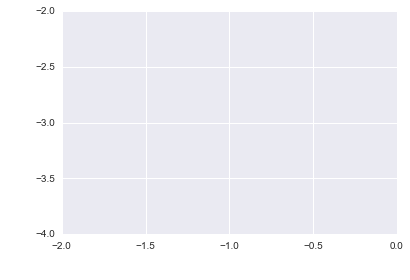

In [216]:
visualiztion(-2, 0, -4, -2)

# 計算兩標籤歐式空間的距離

In [217]:
def tag_distance(tagA, tagB):
    
    id1 = tagdict[tagA]
    id2 = tagdict[tagB]
    
    distance = np.sqrt(np.sum((tagvec[id1] - tagvec[id2])**2))
    print("{} -- {}: {}".format(tagA, tagB, distance))

In [218]:
tagdict

{'acidity': 473,
 'additives': 174,
 'african': 505,
 'aging': 247,
 'alcohol': 173,
 'alcohol-content': 665,
 'alfredo': 97,
 'alkalinity': 489,
 'allergy': 70,
 'allium': 329,
 'almond-milk': 573,
 'almonds': 485,
 'aluminum-cookware': 333,
 'aluminum-foil': 655,
 'american-cuisine': 93,
 'apple': 597,
 'apple-pie': 624,
 'apples': 259,
 'artichokes': 417,
 'asian-cuisine': 198,
 'asparagus': 460,
 'australian-cuisine': 685,
 'avocados': 62,
 'baby-food': 674,
 'bacon': 6,
 'bagels': 542,
 'baker-percentage': 620,
 'baking': 1,
 'baking-powder': 11,
 'baking-soda': 10,
 'balkan-cuisine': 602,
 'bananas': 472,
 'barbecue': 63,
 'barbecue-sauce': 476,
 'barley': 572,
 'basics': 20,
 'basil': 143,
 'basting': 308,
 'batter': 214,
 'bay-leaf': 408,
 'beans': 140,
 'bechamel': 425,
 'beef': 19,
 'beer': 202,
 'beets': 474,
 'bell-peppers': 161,
 'beverages': 203,
 'biga': 707,
 'biscuits': 577,
 'blanching': 445,
 'blender': 127,
 'blind-baking': 169,
 'blowtorch': 456,
 'blueberries': 28

In [227]:
tag_distance('cost', 'whiskey')
tag_distance('cleaning', 'whiskey')
tag_distance('cleaning', 'beer')
tag_distance('cream', 'beer')

cost -- whiskey: 0.810659110546
cleaning -- whiskey: 0.767574489117
cleaning -- beer: 0.922362923622
cream -- beer: 1.01927375793


In [145]:
def normalization_each_row(matrix):
    emp = []
    for row in matrix:
        #base = np.sqrt(np.sum(row**2))
        base = np.sum(row)
        if base > 0:
            emp.append(row / float(base))
        else:
            emp.append(row)
    return np.array(emp)

In [170]:
word_count_matrix = normalization_each_row(word_count_matrix)

In [ ]:
word_count_matrix /= 36